# Chainer CIFAR100

## Combined profile

```
2Feb1854peter@mouse:~$ ./comb_profile.sh ./run_cifar.sh chainer_mouse_combined
Using file names: nvidia-smi-chainer_mouse_combined.csv and nvprof-trace-chainer_mouse_combined-%p.csv
Starting nvidia-smi
/home/peter/.local/lib/python2.7/site-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')
GPU: 0
# Minibatch-size: 1024
# epoch: 2

Using CIFAR100 dataset.
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           4.73795     4.59403               0.0138114      0.0122588                 47.9361
2           4.60124     4.6317                0.0149673      0.0106884                 95.7086
nvidia-smi finished
Starting nvprof
/home/peter/.local/lib/python2.7/site-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')
GPU: 0
# Minibatch-size: 1024
# epoch: 2

Using CIFAR100 dataset.
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           4.67773     4.58299               0.0157047      0.0161631                 49.9652
2           4.5421      4.63707               0.0171995      0.0104632                 98.9316
./comb_profile.sh: line 40: 29148 Terminated              python parse_nvsmi.py nvidia-smi -q -x -lms 100 > $smi_trace
nvprof finished
Traces saved to /home/peter/ nvidia-smi-chainer_mouse_combined.csv and nvprof-trace-chainer_mouse_combined-%p.csv
```

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import os.path
import datetime
from cycler import cycler
import pandas as pd

In [2]:
nvprof_file = "nvprof-trace-chainer_mouse_combined-29174.csv"
nvsmi_file  = "nvidia-smi-chainer_mouse_combined.csv"

In [3]:
nvprof = pd.read_csv(nvprof_file, header=[0], skiprows=[0,1,2,4])
nvprof.iloc[:3]

,Start,Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Device,Context,Stream,Name,Correlation_ID
0,0.353105,0.000960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001953,1.986821,Pinned,Device,Quadro P2000 (0),1,7,[CUDA memcpy HtoD],112
1,0.353222,0.000832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001953,2.292486,Pinned,Device,Quadro P2000 (0),1,7,[CUDA memcpy HtoD],121
2,0.353297,0.000832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001953,2.292486,Pinned,Device,Quadro P2000 (0),1,7,[CUDA memcpy HtoD],131


In [4]:
cols = [1,2,3,4,5,6,7,8,9,10,11,15,16,17,19]
nvprof.drop(nvprof.columns[cols], axis=1, inplace=True)
nvprof.shape

(33895, 5)

In [5]:
# Drop kernels rows (all kernel rows have throughput==0)
nvprof = nvprof[~nvprof["Throughput"].isnull()]
print nvprof.shape
nvprof.iloc[:5]

(1468, 5)


,Start,Throughput,SrcMemType,DstMemType,Name
0,0.353105,1.986821,Pinned,Device,[CUDA memcpy HtoD]
1,0.353222,2.292486,Pinned,Device,[CUDA memcpy HtoD]
2,0.353297,2.292486,Pinned,Device,[CUDA memcpy HtoD]
3,0.353361,2.292486,Pinned,Device,[CUDA memcpy HtoD]
4,0.353426,2.207579,Pinned,Device,[CUDA memcpy HtoD]


In [6]:
nvprof['FullName']   = nvprof['Name'] + " " + nvprof['SrcMemType']+ nvprof['DstMemType'].fillna("")
nvprof.iloc[:3]

,Start,Throughput,SrcMemType,DstMemType,Name,FullName
0,0.353105,1.986821,Pinned,Device,[CUDA memcpy HtoD],[CUDA memcpy HtoD] PinnedDevice
1,0.353222,2.292486,Pinned,Device,[CUDA memcpy HtoD],[CUDA memcpy HtoD] PinnedDevice
2,0.353297,2.292486,Pinned,Device,[CUDA memcpy HtoD],[CUDA memcpy HtoD] PinnedDevice


In [7]:
nvprof["FullName"].unique()

array(['[CUDA memcpy HtoD] PinnedDevice', '[CUDA memset] Device',
       '[CUDA memcpy HtoD] PageableDevice',
       '[CUDA memcpy DtoH] DevicePageable'], dtype=object)

In [8]:
# Convert unique values in column "FullName" to new columns
def mergeColumnNames(df_org):
    df = df_org.pivot(index = 'Start', columns = 'FullName', 
                         values = 'Throughput')
    df = df.fillna(0)  # Fill empty cells with 0-s
    return df

In [9]:
nvprof_m = mergeColumnNames(nvprof)
nvprof_m.iloc[:3]

FullName,[CUDA memcpy DtoH] DevicePageable,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice,[CUDA memset] Device
Start,,,,
0.353105,0.0,0.0,1.986821,0.0
0.353222,0.0,0.0,2.292486,0.0
0.353297,0.0,0.0,2.292486,0.0


In [10]:
def appendMaxValues2ColumnNames(df,series,suff=""):
    cols = len(df.columns)
    col_names = []
    for i in range(0,cols):
        col_names.append(series+df.columns[i]+" " +'{:.3f}'.format(df.iloc[:,i].max()) +" "+suff)
    df.columns = col_names
    return df

In [11]:
nvprof_m = appendMaxValues2ColumnNames(nvprof_m,"",suff="GB/s")
nvprof_m.iloc[:3]

,[CUDA memcpy DtoH] DevicePageable 12.456 GB/s,[CUDA memcpy HtoD] PageableDevice 0.172 GB/s,[CUDA memcpy HtoD] PinnedDevice 11.378 GB/s,[CUDA memset] Device 17166.138 GB/s
Start,,,,
0.353105,0.0,0.0,1.986821,0.0
0.353222,0.0,0.0,2.292486,0.0
0.353297,0.0,0.0,2.292486,0.0


/usr/local/lib/python2.7/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


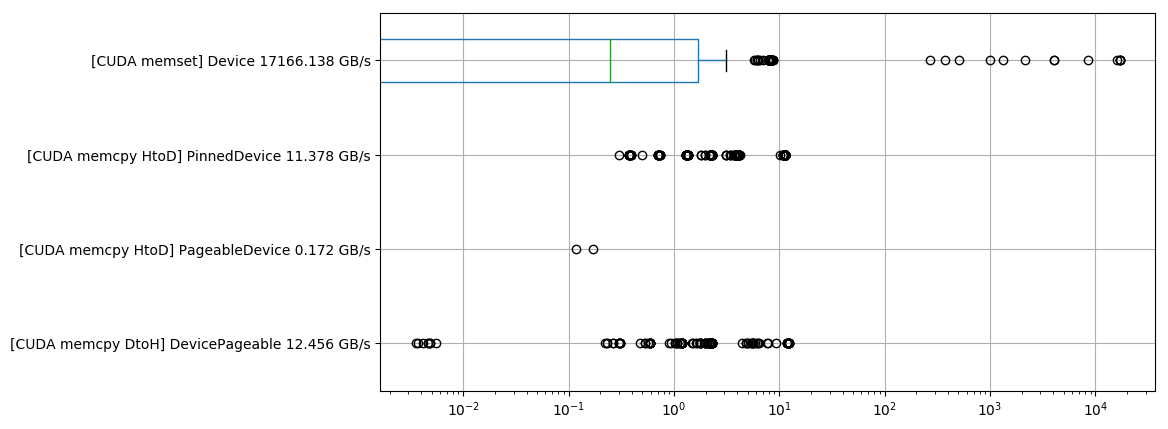

In [12]:
plt.rcParams['figure.figsize'] = 10,5
nvprof_m.plot.box(logx = True, grid = True, vert=False)

In [13]:
x_arr = []
names = []
for column in nvprof_m: 
    x = nvprof_m[column]
    x = x[x != 0]
    arr = x.values
    x_arr.append(arr)
    names.append(column)

In [14]:
# Compare elements of x_arr[3] and nvprof_m column 4 that are greater than 1000
memset = x_arr[3]
memset[memset > 1000]

array([ 17166.137695,   1326.851223,  17166.137695,  16156.36489 ,
         8583.068848,  17166.137695,  17166.137695,   4039.091222,
         4039.091222,   2145.767212,   1009.772806])

In [15]:
nvprof_m[nvprof_m["[CUDA memset] Device 17166.138 GB/s"] > 1000]

,[CUDA memcpy DtoH] DevicePageable 12.456 GB/s,[CUDA memcpy HtoD] PageableDevice 0.172 GB/s,[CUDA memcpy HtoD] PinnedDevice 11.378 GB/s,[CUDA memset] Device 17166.138 GB/s
Start,,,,
2.432108,0.0,0.0,0.0,17166.137695
2.432566,0.0,0.0,0.0,1326.851223
2.432649,0.0,0.0,0.0,17166.137695
2.433128,0.0,0.0,0.0,16156.364890
2.433818,0.0,0.0,0.0,8583.068848
2.434145,0.0,0.0,0.0,17166.137695
2.434749,0.0,0.0,0.0,17166.137695
2.435249,0.0,0.0,0.0,4039.091222
2.435395,0.0,0.0,0.0,4039.091222


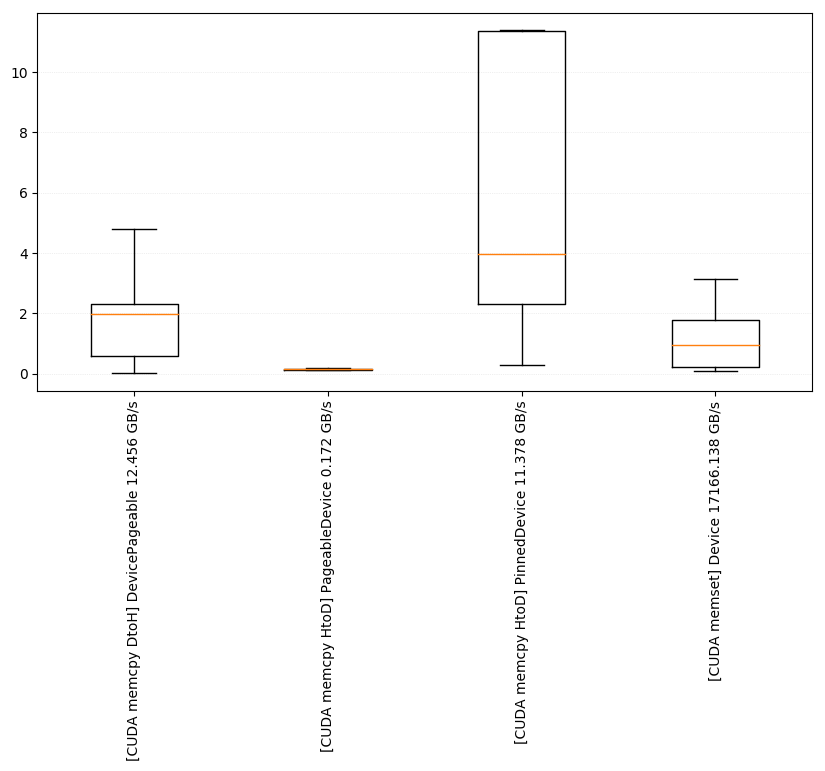

In [16]:
plt.figure()
plt.boxplot(x_arr, 0, '', labels = names)
plt.xticks(rotation=90)
ax = plt.gca()
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
plt.show()

In [21]:
# Drop memset column
nvprof_n = nvprof_m.drop(nvprof_m.columns[3],axis=1)
nvprof_n.iloc[-3:]

,[CUDA memcpy DtoH] DevicePageable 12.456 GB/s,[CUDA memcpy HtoD] PageableDevice 0.172 GB/s,[CUDA memcpy HtoD] PinnedDevice 11.378 GB/s
Start,,,
99.322503,0.596046,0.0,0.0
99.322521,0.596046,0.0,0.0
99.322547,12.279068,0.0,0.0


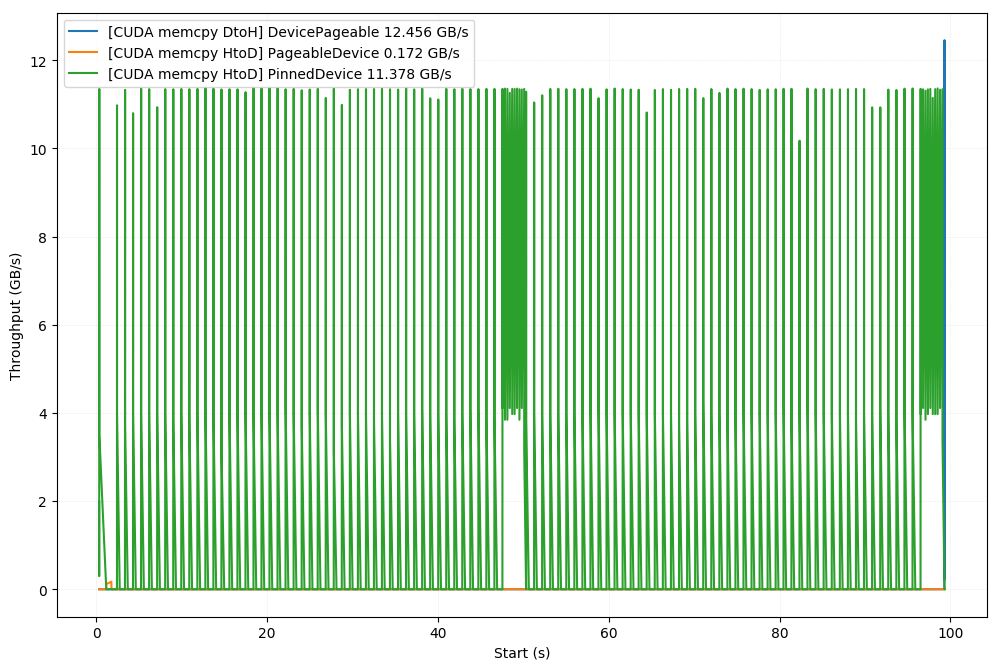

In [22]:
plt.rcParams['figure.figsize'] = 12,8
nvprof_n.plot()
ax = plt.gca()
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.set_xlabel('Start (s)')
ax.set_ylabel('Throughput (GB/s)')
plt.show()

# nvidia-smi data

In [42]:
filename = nvsmi_file
print "Reading",filename

smi_data = pd.read_csv(filename,header=[0], skiprows=[0,1])
smi_data.iloc[-3:]

Reading nvidia-smi-chainer_mouse_combined.csv


,time nvsmi,time python,gpu,PCI sent,PCI recv,GPU util,Memory util,1045 Used Memory,29151 Used Memory
568,Fri Feb 2 18:57:30 2018,2018-02-02 18:57:30.327860,Quadro P2000,3000 KB/s,17000 KB/s,100 %,64 %,241 MiB(1045),4633 MiB(29151)
569,Fri Feb 2 18:57:30 2018,2018-02-02 18:57:30.493299,Quadro P2000,21000 KB/s,51000 KB/s,100 %,40 %,241 MiB(1045),4633 MiB(29151)
570,Fri Feb 2 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
smi_data = smi_data[~smi_data["gpu"].isnull()]
smi_data.iloc[-3:]

,time nvsmi,time python,gpu,PCI sent,PCI recv,GPU util,Memory util,1045 Used Memory,29151 Used Memory
567,Fri Feb 2 18:57:29 2018,2018-02-02 18:57:30.151637,Quadro P2000,20000 KB/s,48000 KB/s,100 %,36 %,241 MiB(1045),4633 MiB(29151)
568,Fri Feb 2 18:57:30 2018,2018-02-02 18:57:30.327860,Quadro P2000,3000 KB/s,17000 KB/s,100 %,64 %,241 MiB(1045),4633 MiB(29151)
569,Fri Feb 2 18:57:30 2018,2018-02-02 18:57:30.493299,Quadro P2000,21000 KB/s,51000 KB/s,100 %,40 %,241 MiB(1045),4633 MiB(29151)


In [44]:
cols = [0,2,7]
smi_data_s = smi_data.drop(smi_data.columns[cols],axis=1)
smi_data_s.iloc[:3]        

,time python,PCI sent,PCI recv,GPU util,Memory util,29151 Used Memory
0,2018-02-02 18:55:56.113415,4000 KB/s,11000 KB/s,0 %,8 %,8 MiB(29151)
1,2018-02-02 18:55:56.274158,50000 KB/s,710000 KB/s,0 %,2 %,107 MiB(29151)
2,2018-02-02 18:55:56.428643,59000 KB/s,341000 KB/s,4 %,1 %,355 MiB(29151)


In [45]:
# Parse date from readable format to seconds
start=0
def parseTime(date_time):
    global start
    if isinstance(date_time,float):
        print date_time,"is float"
        return date_time
    dt_obj = datetime.datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S.%f")
    seconds = 0
    if start == 0:
        start = dt_obj
    else:
        seconds = (dt_obj - start).total_seconds()
    return seconds

In [46]:
smi_data_s["sec"] = smi_data_s["time python"].apply(parseTime)
smi_data_s.iloc[:3]

,time python,PCI sent,PCI recv,GPU util,Memory util,29151 Used Memory,sec
0,2018-02-02 18:55:56.113415,4000 KB/s,11000 KB/s,0 %,8 %,8 MiB(29151),0.000000
1,2018-02-02 18:55:56.274158,50000 KB/s,710000 KB/s,0 %,2 %,107 MiB(29151),0.160743
2,2018-02-02 18:55:56.428643,59000 KB/s,341000 KB/s,4 %,1 %,355 MiB(29151),0.315228


In [47]:
smi_data_s.index = smi_data_s["sec"]
smi_data_s.iloc[:3]

,time python,PCI sent,PCI recv,GPU util,Memory util,29151 Used Memory,sec
sec,,,,,,,
0.000000,2018-02-02 18:55:56.113415,4000 KB/s,11000 KB/s,0 %,8 %,8 MiB(29151),0.000000
0.160743,2018-02-02 18:55:56.274158,50000 KB/s,710000 KB/s,0 %,2 %,107 MiB(29151),0.160743
0.315228,2018-02-02 18:55:56.428643,59000 KB/s,341000 KB/s,4 %,1 %,355 MiB(29151),0.315228


In [48]:
smi_data_s = smi_data_s.drop(smi_data_s.columns[[0,6]],axis=1)
smi_data_s.iloc[:3]

,PCI sent,PCI recv,GPU util,Memory util,29151 Used Memory
sec,,,,,
0.000000,4000 KB/s,11000 KB/s,0 %,8 %,8 MiB(29151)
0.160743,50000 KB/s,710000 KB/s,0 %,2 %,107 MiB(29151)
0.315228,59000 KB/s,341000 KB/s,4 %,1 %,355 MiB(29151)


In [49]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(s):
    global pat
    if not isinstance(s,str):
        print "Not a string:",s
        return s
    f = pat.search(s)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [51]:
smi_data_t = smi_data_s.applymap(parseFloat)
smi_data_t.iloc[-3:]

,PCI sent,PCI recv,GPU util,Memory util,29151 Used Memory
sec,,,,,
94.038222,20000.0,48000.0,100.0,36.0,4633.0
94.214445,3000.0,17000.0,100.0,64.0,4633.0
94.379884,21000.0,51000.0,100.0,40.0,4633.0


In [54]:
smi_data_t.iloc[:3]

,PCI sent,PCI recv,GPU util,Memory util,29151 Used Memory
sec,,,,,
0.000000,4000.0,11000.0,0.0,8.0,8.0
0.160743,50000.0,710000.0,0.0,2.0,107.0
0.315228,59000.0,341000.0,4.0,1.0,355.0


In [53]:
smi_MB = smi_data_t.ix[:,2:4]
smi_MB.iloc[:3]

,GPU util,Memory util
sec,,
0.000000,0.0,8.0
0.160743,0.0,2.0
0.315228,4.0,1.0


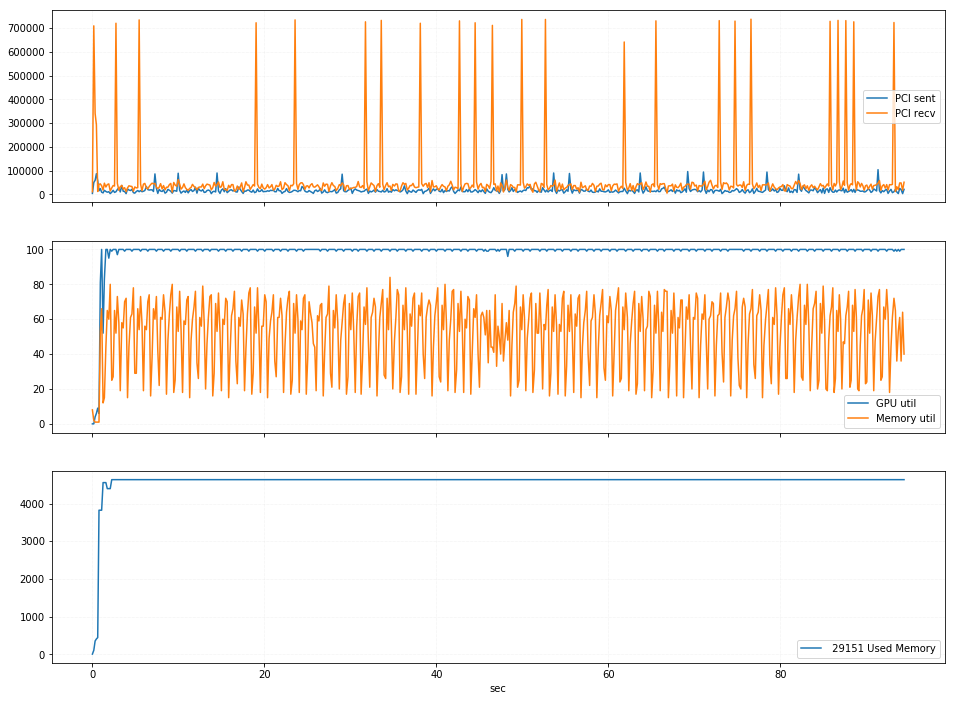

In [59]:
plt.rcParams['figure.figsize'] = 16,12
fig, axarr = plt.subplots(3,sharex=True)
smi_data_t.ix[:,0:2].plot(ax = axarr[0])
smi_data_t.ix[:,2:4].plot(ax = axarr[1])
smi_data_t.ix[:,4:].plot(ax = axarr[2])
axarr[0].yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
axarr[1].yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
axarr[2].yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
axarr[0].xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
axarr[1].xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
axarr[2].xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)